In [ ]:
# importing the necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from math import ceil

In [ ]:
# connecting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# setting the device

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
# setting seed for reproducible results

seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# hyper-parameters

batch_size = 64
learning_rate = 0.001

In [ ]:
# mean, standard deviation for normalization

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
# transforms the image dataset

train_trans = transforms.Compose(
    [
     transforms.RandomResizedCrop((224,224)),   # resize
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)            # normalize for fear of light
                                                # exposure, noise, etc
    ]
)

val_trans = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.CenterCrop((224, 224)),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

In [ ]:
# getting the dataset

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/train',
                                 transform=train_trans,
                                 )

val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/val',
                                 transform=val_trans,
                                 )

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/test',
                                 transform=val_trans,
                                 )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [ ]:
class conv_block (nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding):

        super(conv_block, self).__init__()

        self.conv = nn.Conv2d(in_channels = in_channels,
                              out_channels= out_channels,
                              kernel_size= kernel_size,
                              stride = stride,
                              padding= padding)

        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.relu(self.bn(self.conv(x)))

        return out

class dense_layer (nn.Module):

    def __init__(self, in_channels, growth_rate):
        super(dense_layer, self).__init__()
        # bottleneck

        self.conv1 = conv_block(in_channels = in_channels,
                                out_channels = 4*growth_rate,
                                kernel_size= (1, 1),
                                stride=(1, 1),
                                padding=(0, 0))

        self.conv2 = conv_block(in_channels = 4*growth_rate,
                                out_channels = growth_rate,
                                kernel_size= (3,3),
                                stride=(1,1),
                                padding=(1,1))

    def forward(self, x):

        out = self.conv1(x)
        out = self.conv2(out)

        return torch.cat([x, out], 1)

class transition_block (nn.Module):
    def __init__(self, in_channels, theta=0.5):
        super(transition_block, self).__init__()

        self.cnn = conv_block(in_channels = in_channels,
                              out_channels = int(in_channels*theta),
                              kernel_size=(1,1),
                              stride=(1, 1),
                              padding=(0, 0))

        self.avgpool = nn.AvgPool2d(kernel_size=(2,2),
                                    stride=(2, 2),
                                    padding=(0,0))

    def forward(self, x):

        out = self.cnn(x)
        out = self.avgpool(out)

        return out

class Densenet121 (nn.Module):
    def __init__(self, num_classes, growth_rate=32, theta=0.5):
        super(Densenet121, self).__init__()

        self.first_layer = conv_block(in_channels=3,
                               out_channels=64,
                               kernel_size=(7, 7),
                               stride=(2,2),
                               padding=(3, 3))

        self.pool1 = nn.MaxPool2d(kernel_size=(3,3),
                                  stride=(2,2),
                                  padding=(1,1))

        self.dblock1 = self.dense_block(growth_rate=growth_rate,
                                        in_channels=64,
                                        repeats=6)

        self.t_block1 = transition_block(in_channels=256,
                                         theta=theta)

        self.dblock2 = self.dense_block(growth_rate=growth_rate,
                                        in_channels=128,
                                        repeats=12)

        self.t_block2 = transition_block(in_channels=512,
                                         theta=theta)

        self.dblock3 = self.dense_block(growth_rate=growth_rate,
                                        in_channels=256,
                                        repeats=24)

        self.t_block3 = transition_block(in_channels=1024,
                                         theta=theta)

        self.dblock4 = self.dense_block(growth_rate=growth_rate,
                                        in_channels=512,
                                        repeats=16)

        self.adaptpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=1024, out_features=num_classes)

    def dense_block (self, growth_rate, in_channels, repeats):

        layers = []

        for _ in range(repeats):
            layers.append(dense_layer(in_channels=in_channels,
                                      growth_rate=growth_rate))

            in_channels+=growth_rate

        return nn.Sequential(*layers)


    def forward(self, x):

        out = self.first_layer(x)
        out = self.pool1(out)

        out = self.dblock1(out)
        out = self.t_block1(out)

        out = self.dblock2(out)
        out = self.t_block2(out)

        out = self.dblock3(out)
        out = self.t_block3(out)

        out = self.dblock4(out)
        out = self.adaptpool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        return out

In [ ]:
# calling the model

model = Densenet121(num_classes=2, growth_rate=32, theta=0.5).to(device)

In [ ]:
print(model)

Densenet121(
  (first_layer): conv_block(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (dblock1): Sequential(
    (0): dense_layer(
      (conv1): conv_block(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (conv2): conv_block(
        (conv): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (1): dense_layer(
      (conv1): conv_block(
        (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, m

In [ ]:
# setting the loss metric and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# open this block for training on checkpoint
# checkpoint = torch.load('/content/drive/MyDrive/mobilenetv1_on_hymeno.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['model_optimizer'])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# tuning the learning rate

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# measuring time taken running the epochs

def calculate_time (time_elapsed):
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    if minutes > 60:
        hours = minutes // 60
        new_minutes = minutes % 60
        print(f'Training complete in {hours:.0f}h {new_minutes:.0f}m {seconds:.0f}s')
    else:
        print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')

In [ ]:
# hyper-parameters

num_epochs = 30
val_acc_hist = []
train_acc_hist = []
loss_train = []
loss_val = []
best_acc = 0.0

In [ ]:
# training loop

start = time.time()

for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0
    running_corrects = 0

    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        z_scores = model(images)
        loss = criterion(z_scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predictions = torch.max(z_scores, 1)
        running_corrects += torch.sum(predictions == labels)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    print(f'Epoch {epoch+1} / {num_epochs}, '
          f'Train Loss {epoch_loss:.4f}, '
          f'Train Acc {epoch_acc:.4f}')

    train_acc_hist.append(epoch_acc)
    loss_train.append(epoch_loss)

    step_lr_scheduler.step()

    model.eval()

    running_loss = 0.0
    running_corrects = 0

    for idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            z_scores = model(images)
            loss = criterion(z_scores, labels)

            running_loss += loss.item() * images.size(0)
            _, predictions = torch.max(z_scores, 1)
            running_corrects += torch.sum(predictions == labels)

    epoch_loss_val = running_loss / len(val_dataset)
    epoch_acc_val = running_corrects / len(val_dataset)
    print(f'Epoch {epoch + 1} / {num_epochs}, '
          f'Val Loss {epoch_loss_val:.4f}, '
          f'Val Acc {epoch_acc_val:.4f}')

    val_acc_hist.append(epoch_acc_val)
    loss_val.append(epoch_loss_val)

    if epoch_acc_val > best_acc:
        best_acc = epoch_acc_val

time_elapsed = time.time() - start

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 / 30, Train Loss 0.7492, Train Acc 0.5738
Epoch 1 / 30, Val Loss 0.7013, Val Acc 0.4301
Epoch 2 / 30, Train Loss 0.6783, Train Acc 0.6311
Epoch 2 / 30, Val Loss 0.6898, Val Acc 0.4946
Epoch 3 / 30, Train Loss 0.5955, Train Acc 0.6475
Epoch 3 / 30, Val Loss 0.6707, Val Acc 0.5484
Epoch 4 / 30, Train Loss 0.5449, Train Acc 0.7090
Epoch 4 / 30, Val Loss 0.6150, Val Acc 0.6129
Epoch 5 / 30, Train Loss 0.5797, Train Acc 0.6721
Epoch 5 / 30, Val Loss 0.5533, Val Acc 0.7097
Epoch 6 / 30, Train Loss 0.5181, Train Acc 0.7418
Epoch 6 / 30, Val Loss 0.5322, Val Acc 0.7204
Epoch 7 / 30, Train Loss 0.5237, Train Acc 0.7172
Epoch 7 / 30, Val Loss 0.7372, Val Acc 0.6237
Epoch 8 / 30, Train Loss 0.4736, Train Acc 0.7746
Epoch 8 / 30, Val Loss 0.5900, Val Acc 0.6344
Epoch 9 / 30, Train Loss 0.4789, Train Acc 0.7623
Epoch 9 / 30, Val Loss 0.5327, Val Acc 0.7204
Epoch 10 / 30, Train Loss 0.4779, Train Acc 0.7746
Epoch 10 / 30, Val Loss 0.5153, Val Acc 0.7204
Epoch 11 / 30, Train Loss 0.4286, Trai

In [ ]:
calculate_time(time_elapsed)

Training complete in 5m 51s


In [ ]:
print(f'Best validation Accuracy: {best_acc:.4f}')

Best validation Accuracy: 0.7957


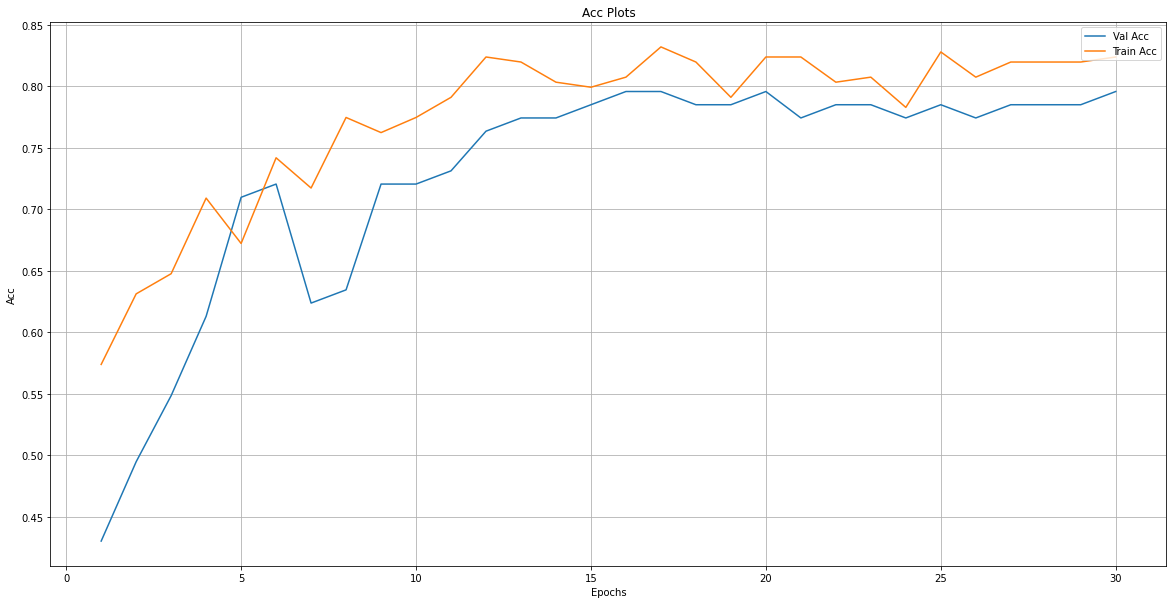

In [ ]:
# visualizing training and validating accuracy

val_acc_hist_numpy = [acc.cpu().numpy() for acc in val_acc_hist]
train_acc_hist_numpy = [acc.cpu().numpy() for acc in train_acc_hist]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), val_acc_hist_numpy, label='Val Acc')
plt.plot(range(1, num_epochs+1), train_acc_hist_numpy, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title("Acc Plots")
plt.legend(loc='upper right')
plt.show()

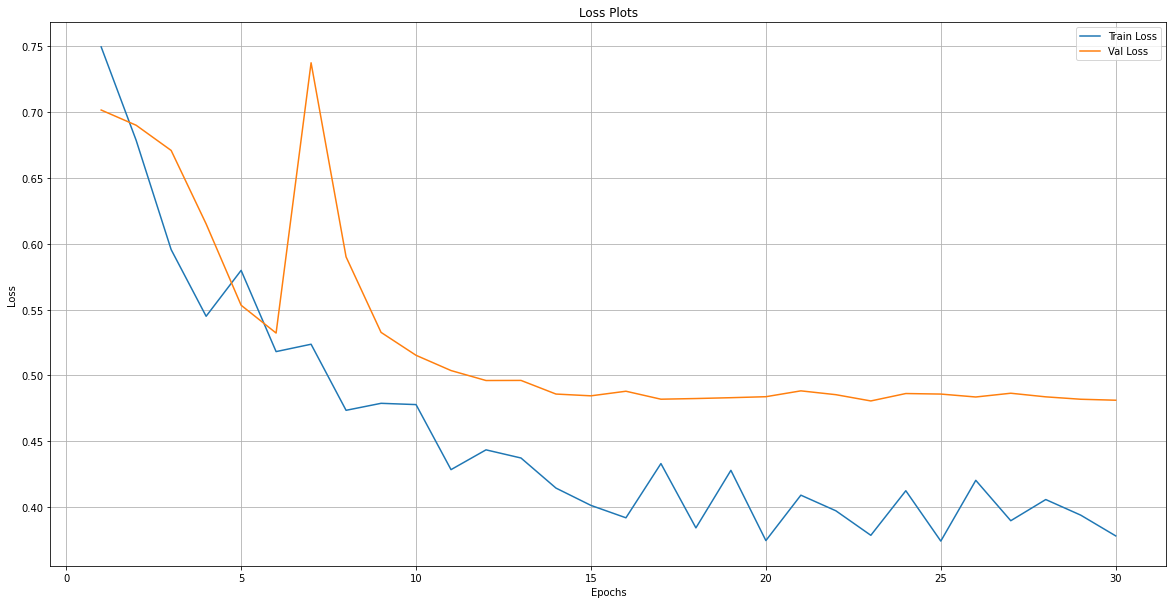

In [ ]:
# visualizing training and validating loss

plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
# testing the model

model.eval()

running_corrects = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        z_scores = model(images)

        _, predictions = torch.max(z_scores,1)
        running_corrects += torch.sum(predictions == labels)

    acc = running_corrects / len(test_dataset)
    print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.7333


In [ ]:
# saving model

checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_optimizer': optimizer.state_dict(),
                'val_acc_hist': val_acc_hist,
                'train_acc_hist': train_acc_hist,
                'loss_train': loss_train,
                'loss_val': loss_val,
                'best_acc': best_acc
}

torch.save(checkpoint, '/content/drive/MyDrive/densenet_on_hymeno.pth')